In [1]:
# Mini GPT-style Language Model with LoRA Fine-tuning on Synthetic Character Data

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
import string
import matplotlib.pyplot as plt
from peft import get_peft_model, LoraConfig, TaskType


In [2]:

# ----------------------------
# 1. Data Generation
# ----------------------------
def generate_capital_char_data(num_sequences=10000, seq_length=10):
    data = []
    for _ in range(num_sequences):
        seq = ''.join(random.choices(string.ascii_uppercase, k=seq_length))
        data.append(seq)
    return data

def generate_alternating_data(num_sequences=10000, seq_length=10):
    data = []
    for _ in range(num_sequences):
        seq = []
        for i in range(seq_length):
            if i % 2 == 0:  # Even positions get digits
                seq.append(str(random.randint(0, 9)))
            else:  # Odd positions get capital letters
                seq.append(random.choice(string.ascii_uppercase))
        data.append(''.join(seq))
    return data

def generate_random_char_data(num_sequences=10000, seq_length=10):
    data = []
    for _ in range(num_sequences):
        seq = ''.join(random.choices(string.ascii_letters, k=seq_length))
        data.append(seq)
    return data

def generate_data_pairs(num_sequences=10000, seq_length=10):
    data = []
    for _ in range(num_sequences):
        # Generate sequence where no char appears more than twice
        chars = []
        used_chars = {}
        while len(chars) < seq_length:
            char = random.choice(string.ascii_letters).upper()
            if used_chars.get(char, 0) < 2:  # Only use char if it appears < 2 times
                chars.append(char)
                used_chars[char] = used_chars.get(char, 0) + 1
        data.append(''.join(chars))
    return data

def generate_data_words(num_sequences=10000):
    # Common English words (just a small sample for demonstration)
    # Use NLTK's built-in word list for more comprehensive vocabulary
    import nltk
    try:
        nltk.data.find('corpora/words')
    except LookupError:
        nltk.download('words')
    from nltk.corpus import words
    
    # Get common English words from NLTK, filtering for reasonable word lengths
    common_words = [word.lower() for word in words.words() if 2 <= len(word) <= 18 and word.isalpha()][:1000]
    
    data = []
    for _ in range(num_sequences):
        # Select 1-3 random words
        num_words = random.randint(1, 3)
        sequence = []
        for _ in range(num_words):
            word = random.choice(common_words)
            # Truncate word if longer than 10 characters, or pad with random chars if shorter
            word = word[:10] if len(word) > 10 else word + ''.join(random.choices(string.ascii_lowercase, k=10-len(word)))
            sequence.append(word)
            
        # Join words together
        final_sequence = ''.join(sequence)
        data.append(final_sequence)
    
    return data


def generate_increasing_ascii_data(num_sequences=1000, seq_length=10):
    data = []
    for _ in range(num_sequences):
        chars = []
        prev_val = random.randint(32, 126 - seq_length)  # Start with printable ASCII
        for _ in range(seq_length):
            chars.append(chr(prev_val))
            # Ensure next char has higher ASCII value but stays within printable range
            next_min = prev_val + 1
            next_max = min(prev_val + 10, 126)
            if next_min <= next_max:  # Only generate if valid range exists
                prev_val = random.randint(next_min, next_max)
            else:
                break  # Stop if we can't generate a higher value
        if len(chars) == seq_length:  # Only add complete sequences
            data.append(''.join(chars))
    return data

def generate_data_palindrome(num_sequences=1000, seq_length=10):
    data = []
    for _ in range(num_sequences):
        # For odd length sequences, handle middle character separately
        half_length = seq_length // 2
        is_odd = seq_length % 2 == 1
        
        # Generate first half ensuring no char appears more than once
        available_chars = list(string.ascii_lowercase)
        first_half = []
        for _ in range(half_length):
            if not available_chars:
                break
            char = random.choice(available_chars)
            first_half.append(char)
            available_chars.remove(char)
        
        first_half = ''.join(first_half)
        
        # Create palindrome by reversing first half
        if is_odd:
            # Add random middle character that wasn't used in first half
            available_chars = [c for c in string.ascii_lowercase if c not in first_half]
            if available_chars:
                middle = random.choice(available_chars)
                palindrome = first_half + middle + first_half[::-1]
            else:
                palindrome = first_half + 'x' + first_half[::-1]
        else:
            palindrome = first_half + first_half[::-1]
            
        data.append(palindrome)
    
    return data


In [3]:

# ----------------------------
# 2. Dataset and Tokenizer
# ----------------------------
class CharTokenizer:
    def __init__(self):
        chars = string.ascii_uppercase + string.digits
        self.char2idx = {ch: i for i, ch in enumerate(chars)}
        self.idx2char = {i: ch for ch, i in self.char2idx.items()}
        self.vocab_size = len(chars)

    def encode(self, text):
        
        return [self.char2idx[ch] for ch in text]

    def decode(self, indices):
        return ''.join([self.idx2char[i] for i in indices])
    
    def get_vocab(self):
        return list(self.char2idx.keys())

tokenizer = CharTokenizer()


In [4]:

class CharDataset(Dataset):
    def __init__(self, sequences, tokenizer):
        self.sequences = sequences
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        tokens = self.tokenizer.encode(self.sequences[idx])
        return torch.tensor(tokens[:-1]), torch.tensor(tokens[1:])


In [5]:

# ----------------------------
# 3. Mini GPT Model
# ----------------------------
class MiniGPT(nn.Module):
    def __init__(self, vocab_size, dim=16, n_layers=3):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, dim)
        self.pos_embed = nn.Parameter(torch.randn(10, dim))
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=dim, nhead=4, dim_feedforward=64)
            for _ in range(n_layers)
        ])
        self.ln = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, vocab_size)
        
        # Add config attribute with dictionary-like behavior
        class Config:
            def __init__(self):
                self.use_return_dict = False
                self.vocab_size = vocab_size
                self.hidden_size = dim
                self.num_hidden_layers = n_layers
                self.num_attention_heads = 4
                self.tie_word_embeddings = False
            
            def get(self, key, default=None):
                return getattr(self, key, default)
        
        self.config = Config()

    def forward(self, *args, **kwargs):
        # Handle both positional and keyword arguments
        if len(args) > 0:
            x = args[0]
        elif 'input_ids' in kwargs:
            x = kwargs['input_ids']
        elif isinstance(kwargs.get('inputs', None), dict):
            x = kwargs['inputs']['input_ids']
        else:
            raise ValueError("No input provided to forward method")
        
        B, T = x.size()
        x = self.token_embed(x) + self.pos_embed[:T]
        for layer in self.layers:
            x = layer(x)
        x = self.ln(x)
        return self.head(x)


In [6]:

# ----------------------------
# 4. Training Function
# ----------------------------
def train_model(model, dataloader, optimizer, epochs=5, is_lora=False):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in dataloader:
            logits = model(xb)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), yb.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

        if is_lora:
            visualize_lora_params(model, epoch+1)
        # Also visualize weights of linear layers with LoRA
        if is_lora:
            linear_weights = []
            linear_names = []
            for name, param in model.named_parameters():
                if any(target in name for target in ['linear1', 'linear2', 'head']) and 'weight' in name and 'lora' not in name:
                    linear_weights.append(param.detach().cpu().flatten())
                    linear_names.append(name)

            if linear_weights:
                for weights, name in zip(linear_weights, linear_names):
                    plt.figure(figsize=(10, 2))
                    plt.hist(weights.numpy(), bins=50, alpha=0.5, label=name)
                    plt.title(f"{name} Weights at Epoch {epoch}")
                    plt.legend()
                    plt.show()
    return losses


In [7]:

# ----------------------------
# 5. Visualize LoRA Parameters
# ----------------------------
def visualize_lora_params(model, epoch):
    lora_weights_A = []
    lora_weights_B = []
    for name, param in model.named_parameters():
        if 'lora_A' in name and 'weight' in name:
            lora_weights_A.append(param.detach().cpu().flatten())
        elif 'lora_B' in name and 'weight' in name:
            lora_weights_B.append(param.detach().cpu().flatten())

    if lora_weights_A:
        flat_A = torch.cat(lora_weights_A)
        plt.figure(figsize=(10, 2))
        plt.hist(flat_A.numpy(), bins=50, color='blue', label='LoRA A')
        plt.title(f"LoRA A Parameters at Epoch {epoch}")
        plt.legend()
        plt.show()

    if lora_weights_B:
        flat_B = torch.cat(lora_weights_B)
        plt.figure(figsize=(10, 2))
        plt.hist(flat_B.numpy(), bins=50, color='red', label='LoRA B') 
        plt.title(f"LoRA B Parameters at Epoch {epoch}")
        plt.legend()
        plt.show()


In [8]:

# ----------------------------
# 6. Main Script
# ----------------------------

# Pretraining
pretrain_sequences = generate_data_pairs(num_sequences=50000, seq_length=10)
pretrain_dataset = CharDataset(pretrain_sequences, tokenizer)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=32, shuffle=True)
# Save pretrain sequences to file for reproducibility
with open('train_char_data.txt', 'w') as f:
    for seq in pretrain_sequences:
        f.write(seq + '\n')

model = MiniGPT(vocab_size=tokenizer.vocab_size)
print("Tokenizer vocab size:", tokenizer.vocab_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_model(model, pretrain_loader, optimizer, epochs=5)
# Generate some sample outputs from pretrained model
print("\nSample outputs from pretrained model:")
model.eval()
with torch.no_grad():
    for i in range(10):
        # Start with a random character as seed
        seed = random.choice(tokenizer.get_vocab()) 
        x = torch.tensor([tokenizer.encode(seed)], dtype=torch.long)
        output = []
        
        # Generate 9 more characters
        for _ in range(9):
            logits = model(x)
            next_token = torch.argmax(logits[0, -1]).item()
            output.append(next_token)
            x = torch.cat([x, torch.tensor([[next_token]])], dim=1)
        
        generated = seed + tokenizer.decode(output)
        print(f"Sample {i+1}: {generated}")
model.train()

# Debug: Print model parameter names
# print("Model parameter names:")
# for name, _ in model.named_parameters():
#     print(name)


Tokenizer vocab size: 36
Epoch 1: Loss = 3.2787
Epoch 2: Loss = 3.2610
Epoch 3: Loss = 3.2601
Epoch 4: Loss = 3.2598
Epoch 5: Loss = 3.2594

Sample outputs from pretrained model:
Sample 1: 1RRRRRRRRR
Sample 2: ZRRRRRRRRR
Sample 3: 4RRRRRRRRR
Sample 4: HRRRRRRRRR
Sample 5: SRRRRRRRRR
Sample 6: YRRRRRRRRR
Sample 7: TRRRRRRRRR
Sample 8: ERRRRRRRRR
Sample 9: GRRRRRRRRR
Sample 10: TRRRRRRRRR


MiniGPT(
  (token_embed): Embedding(36, 16)
  (layers): ModuleList(
    (0-2): 3 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
      )
      (linear1): Linear(in_features=16, out_features=64, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=64, out_features=16, bias=True)
      (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (ln): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=16, out_features=36, bias=True)
)

Epoch 1: Loss = 3.9434


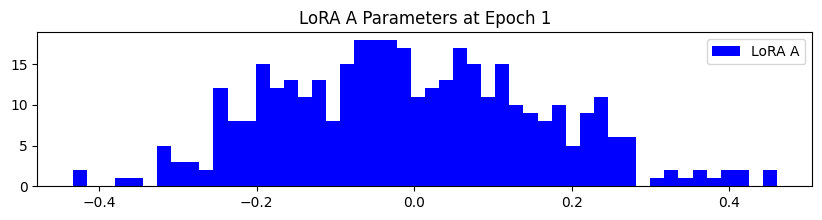

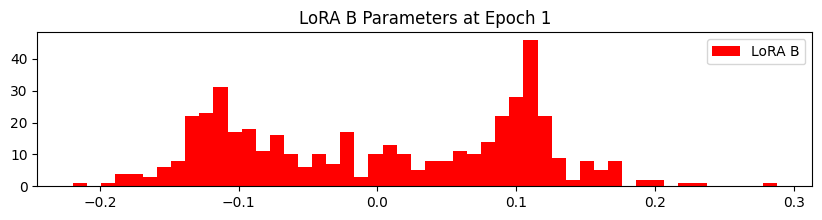

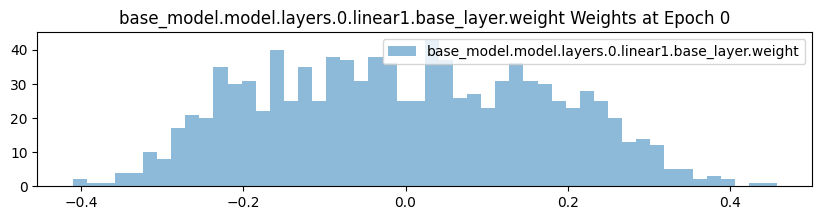

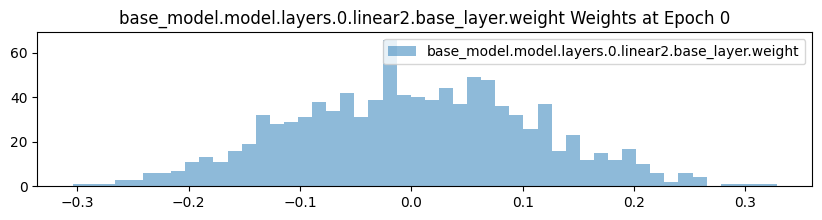

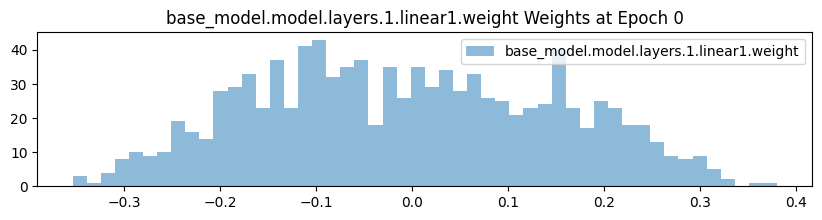

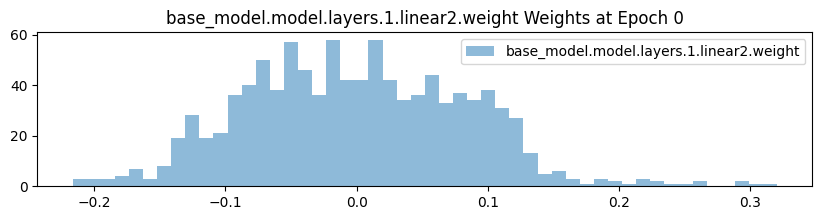

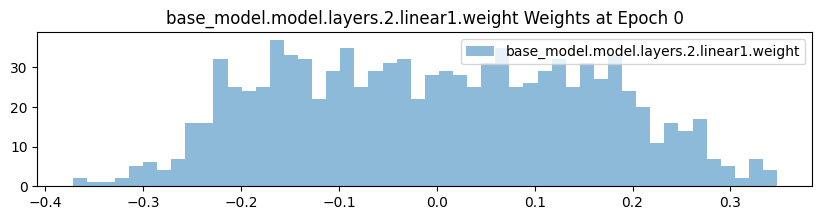

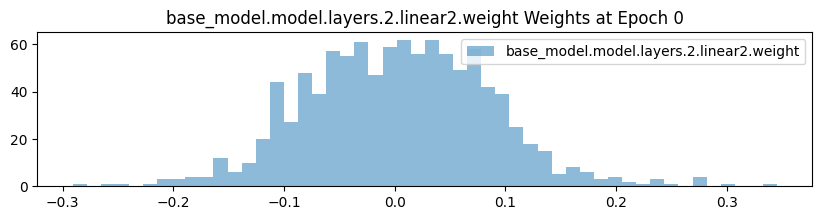

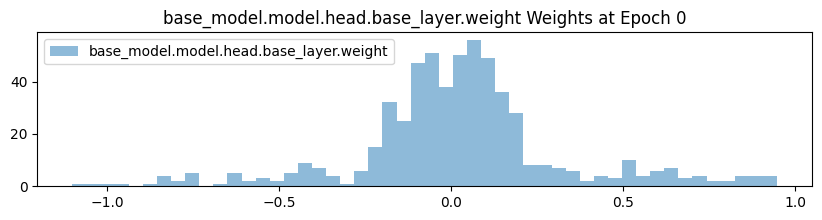

Epoch 2: Loss = 2.8724


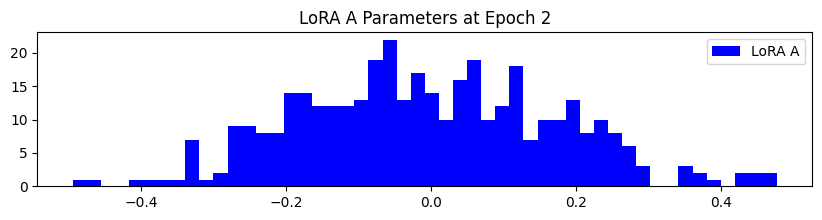

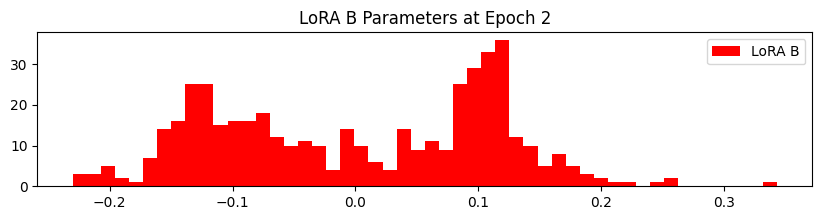

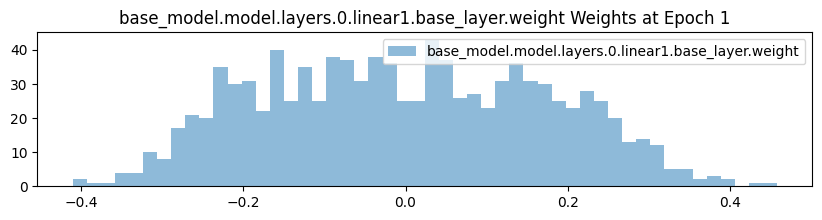

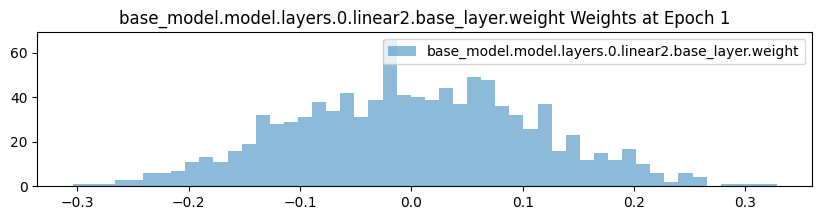

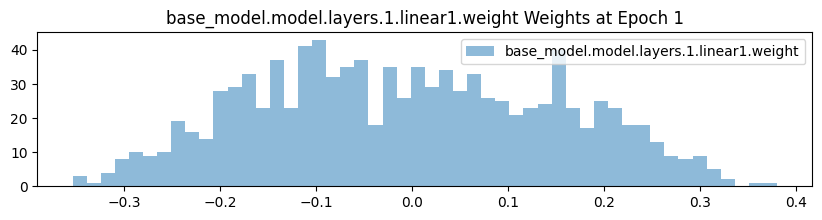

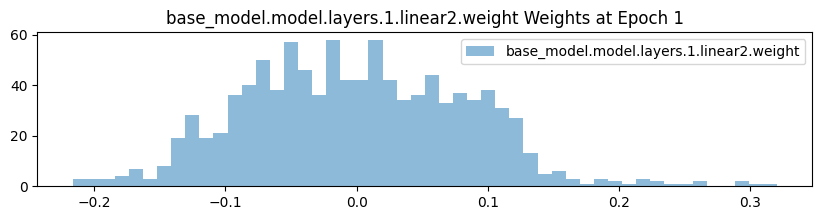

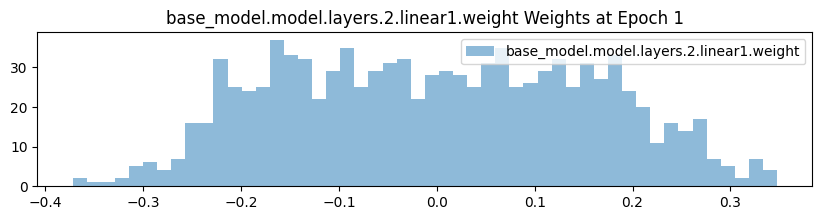

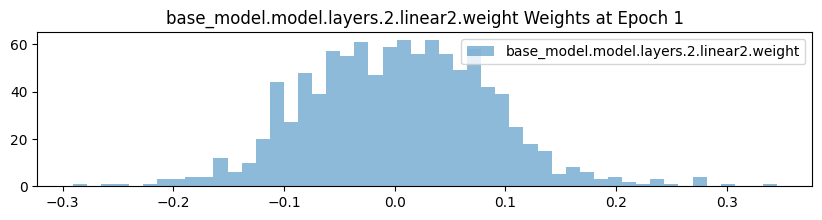

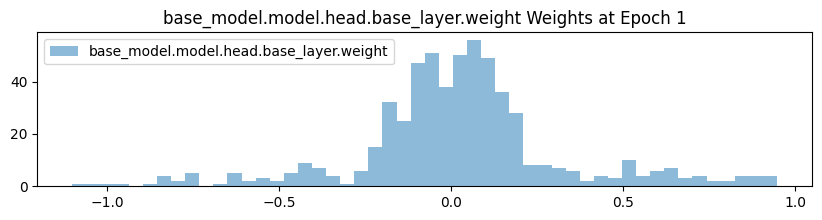

Epoch 3: Loss = 2.8571


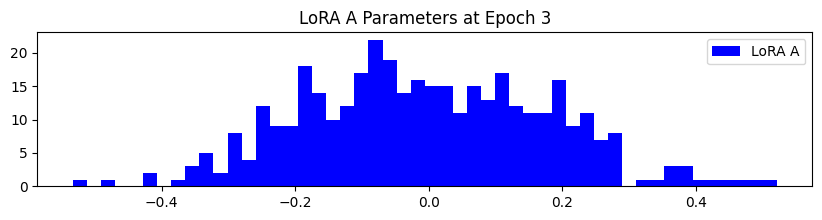

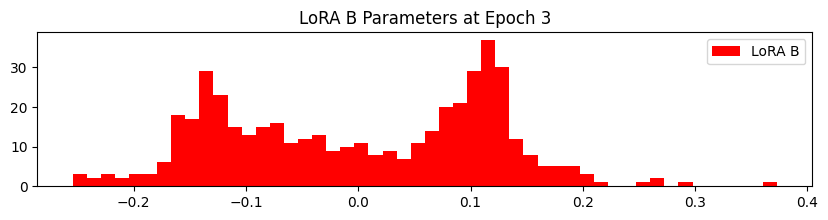

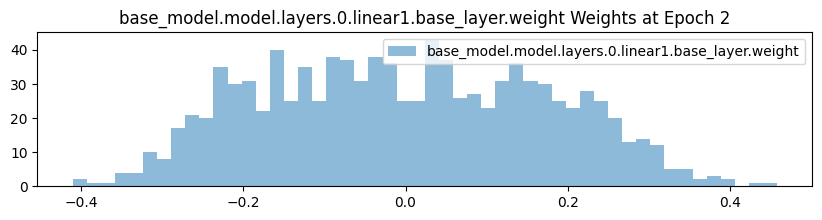

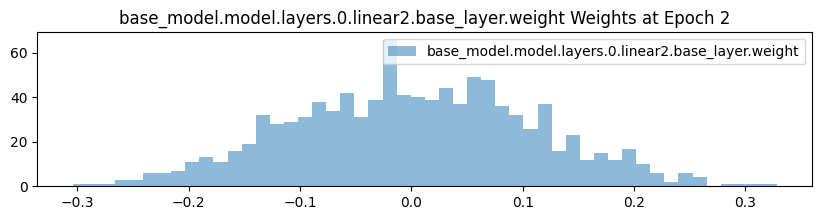

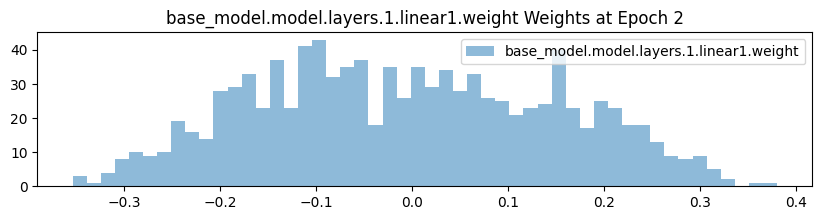

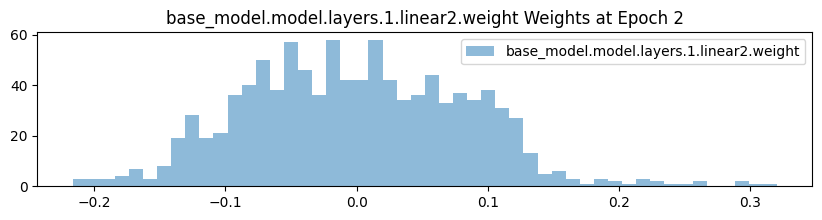

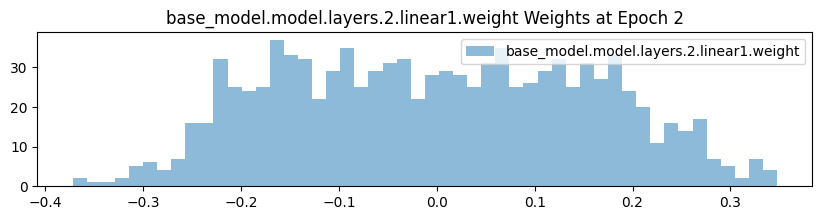

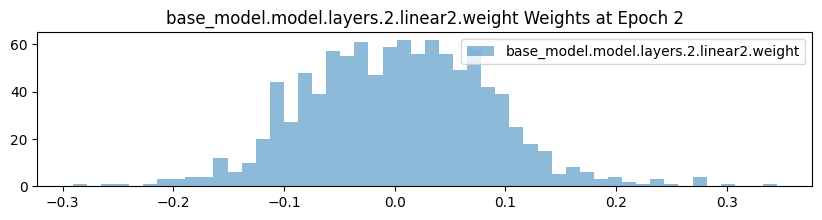

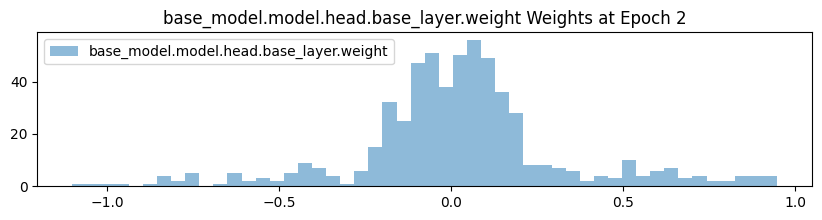

Epoch 4: Loss = 2.8515


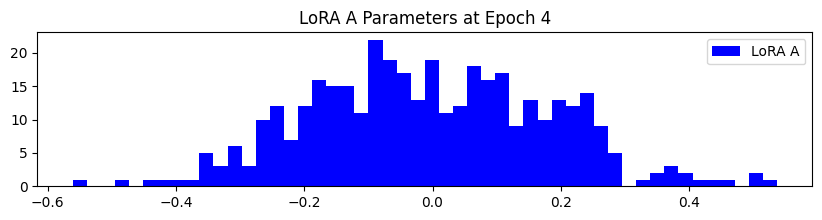

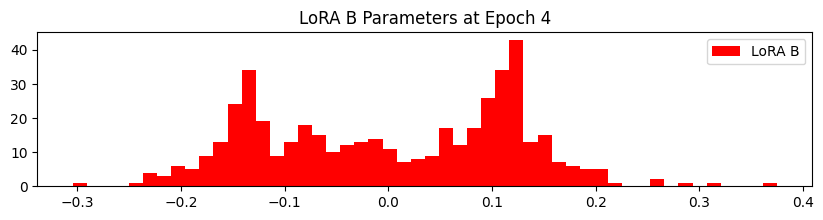

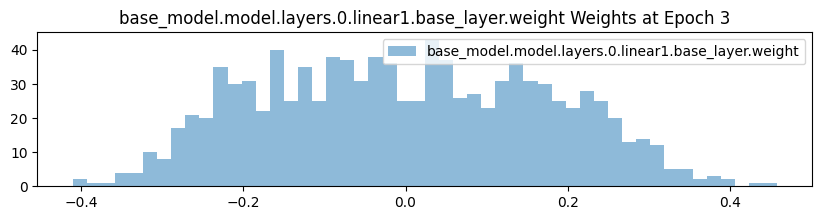

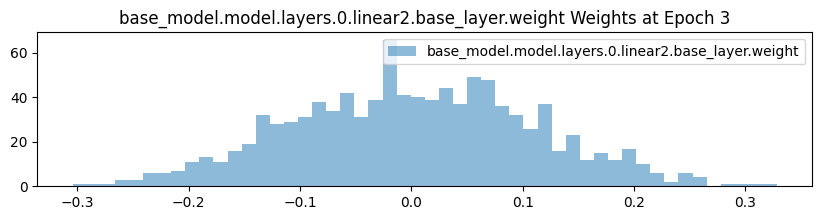

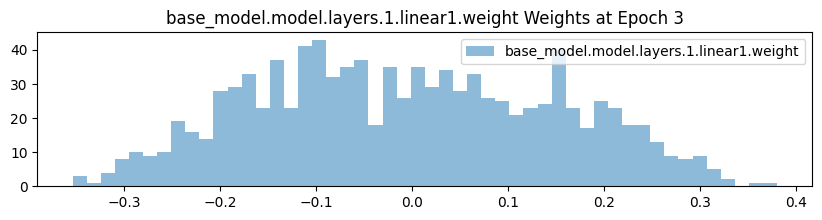

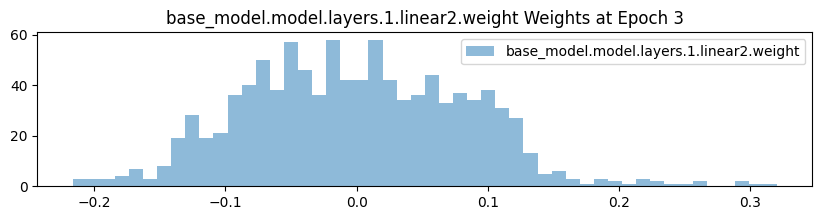

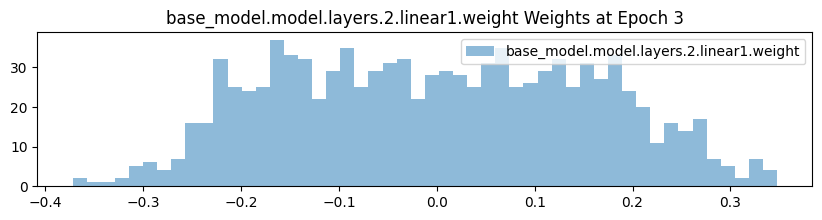

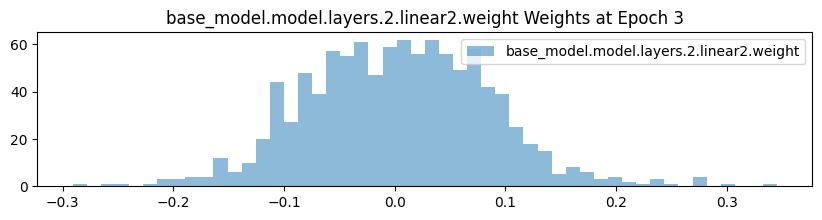

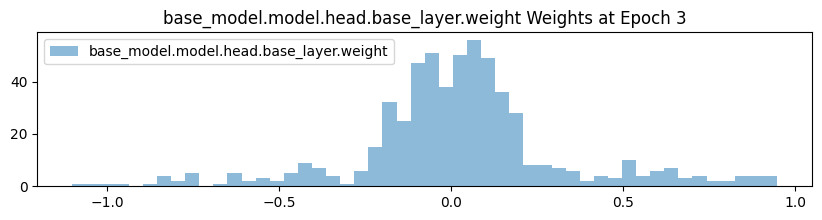

Epoch 5: Loss = 2.8496


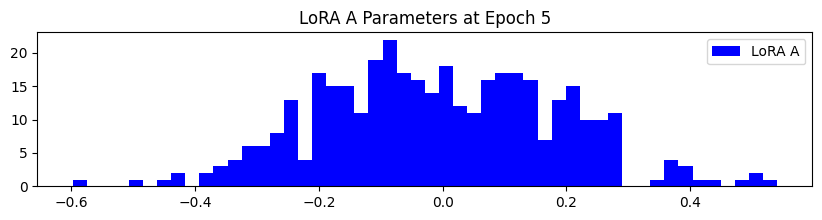

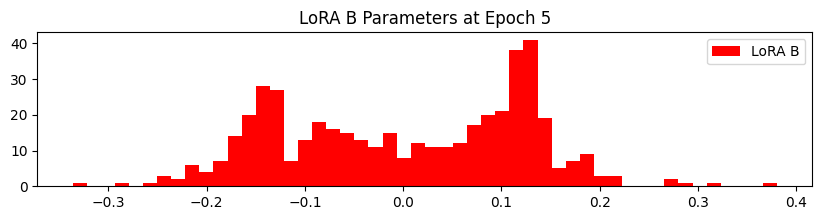

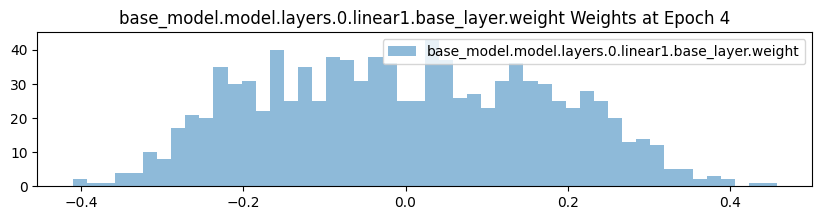

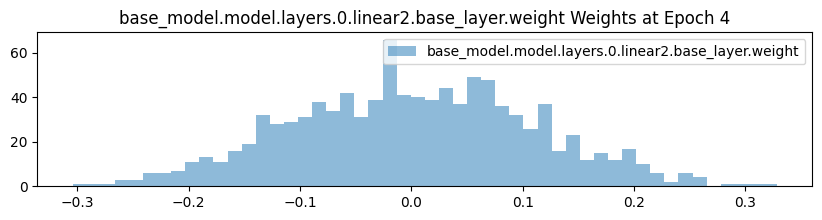

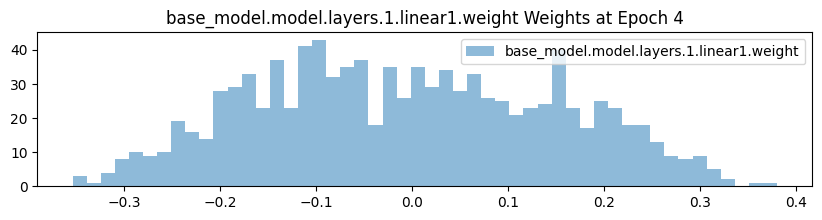

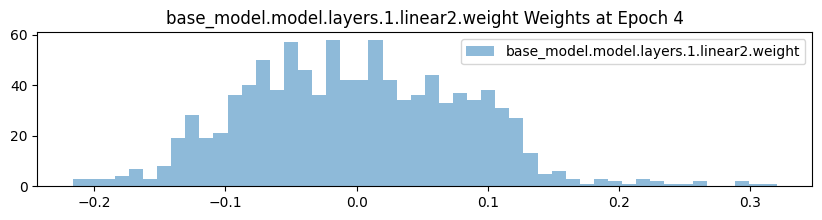

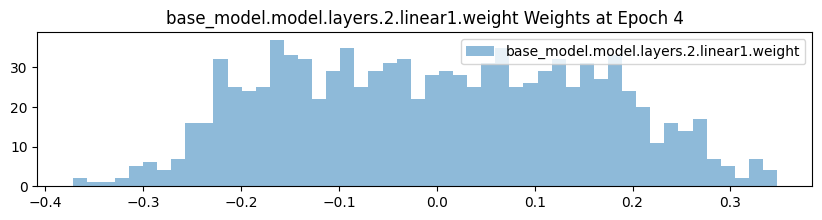

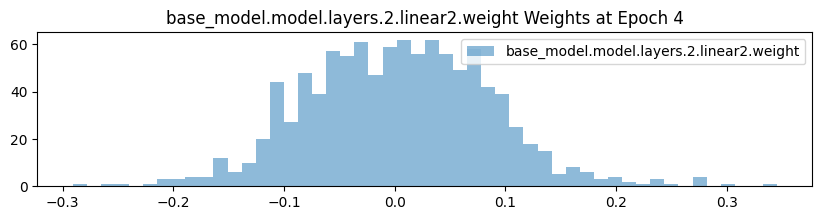

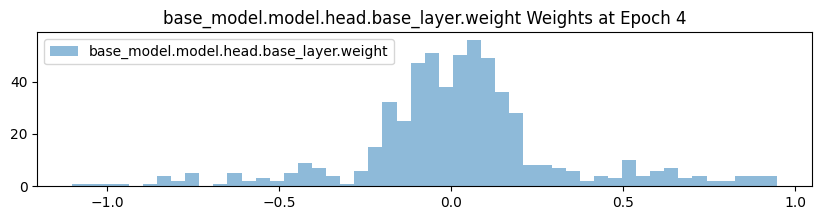

[3.9433733944694835,
 2.8723787903404845,
 2.8570910528445017,
 2.8515317219133958,
 2.8495958148480987]

In [9]:

# LoRA Fine-tuning
finetune_sequences = generate_alternating_data(num_sequences=10000, seq_length=10)
finetune_dataset = CharDataset(finetune_sequences, tokenizer)
finetune_loader = DataLoader(finetune_dataset, batch_size=32, shuffle=True)
# Save finetune sequences to file for reproducibility
with open('finetune_char_data.txt', 'w') as f:
    for seq in finetune_sequences:
        f.write(seq + '\n')

lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=['layers.0.linear1', 'layers.0.linear2', 'head'],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model_lora = get_peft_model(model, lora_config)
optimizer_lora = torch.optim.Adam(model_lora.parameters(), lr=1e-3)
train_model(model_lora, finetune_loader, optimizer_lora, epochs=5, is_lora=True)



In [10]:
# Generate samples from fine-tuned model
print("\nSample outputs from fine-tuned model:")
model_lora.eval()
with torch.no_grad():
    for i in range(10):
        # Start with a random character as seed
        seed = random.choice(tokenizer.get_vocab())
        x = torch.tensor([tokenizer.encode(seed)], dtype=torch.long)
        output = []
        
        # Generate 9 more characters
        for _ in range(9):
            logits = model_lora(x)
            next_token = torch.argmax(logits[0, -1]).item()
            output.append(next_token)
            x = torch.cat([x, torch.tensor([[next_token]])], dim=1)
        
        generated = seed + tokenizer.decode(output)
        print(f"Sample {i+1}: {generated}")
model_lora.train()



Sample outputs from fine-tuned model:
Sample 1: 3R2R6R6R6R
Sample 2: JR2R6R6R6R
Sample 3: IR2R6R6R6R
Sample 4: 2R2R6R6R6R
Sample 5: 8R2R6R6R6R
Sample 6: 5A2R6R6R6R
Sample 7: NA2R6R6R6R
Sample 8: 7A2R6R6R6R
Sample 9: 0R2R6R6R6R
Sample 10: DR2R6R6R6R


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): MiniGPT(
      (token_embed): Embedding(36, 16)
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): lora.Linear(
            (base_layer): Linear(in_features=16, out_features=64, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=16, out_features=4, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=4, out_features=64, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (dropout): Dropout